<a href="https://colab.research.google.com/github/ziatdinovmax/GPim/blob/master/examples/notebooks/GP_TD_cKPFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian processes and tensor decomposition in cKPFM
Prepared by Maxim Ziatdinov (Gaussian processes) and Rama K. Vasudevan (Tensor decomposition)

Email: maxim.ziatdinov@ai4microscopy.com

This notebook demonstates i) application of Gaussian process regression to smoothing and enhancing resolution of cKPFM data, ii) application of tensor decomposition to the cKPFM data after Gaussian process.

Check Cloud GPU (should have at least 12 GB memory):

In [0]:
!nvidia-smi

Wed Feb 19 17:15:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
#@title Install/Import modules { form-width: "20%" }

!pip install -q git+https://github.com/ziatdinovmax/GPim.git
!pip install -q tensorly

import os
import copy
import h5py
import numpy as np
from sklearn import decomposition
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import torch
from gpim import gprutils, skgpr    
import tensorly
from tensorly.decomposition import parafac
from tensorly.decomposition import non_negative_parafac

torch.set_default_tensor_type(torch.DoubleTensor)

     |████████████████████████████████| 491kB 11.3MB/s 
     |████████████████████████████████| 235kB 53.2MB/s 
     |████████████████████████████████| 61kB 10.6MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 163kB 28.1MB/s 


In [0]:
#@title Helper functions { form-width: "20%" }
def range2(bias_vec, x1, x2):
    range_ = x2 - x1
    bias_vec = (bias_vec - np.min(bias_vec)) / np.ptp(bias_vec)
    bias_vec = bias_vec * range_ + np.min(x1)
    return bias_vec


def dense2x_w(bias_vec, n=2):
    _bias_vec = np.empty(0)
    avg_step = np.mean(np.abs(np.diff(bias_vec)))
    for i in range(len(bias_vec)):
        if i + 1 < len(bias_vec):
            bias_vec_i1 = bias_vec[i]
            bias_vec_i2 = bias_vec[i+1]
            bias_vec_i1i2 = np.linspace(bias_vec_i1, bias_vec_i2, n, endpoint=False)
        else:
            bias_vec_i1 = bias_vec[i]
            bias_vec_i2 = bias_vec[i] + avg_step
            bias_vec_i1i2 = np.linspace(bias_vec_i1, bias_vec_i2, n, endpoint=False)
        _bias_vec = np.append(_bias_vec, bias_vec_i1i2)
    _bias_vec = range2(_bias_vec, np.min(bias_vec), np.max(bias_vec))
    return _bias_vec


def dense2x_r(bias_vec, n):
    bias_vec_min = bias_vec[0][0]
    bias_vec_max = bias_vec[0][-1]
    _bias_vec = np.linspace(bias_vec_min, bias_vec_max,
                            len(bias_vec[0])*n)
    _bias_vec = range2(_bias_vec, np.min(bias_vec), np.max(bias_vec))
    _bias_vec = np.tile(
        _bias_vec,(bias_vec.shape[0]*n)).reshape(
            bias_vec.shape[0]*n, bias_vec.shape[1]*n)
    return _bias_vec


def plot_line_family(axis, x_vec, line_family, line_names=None, label_prefix='',
                     label_suffix='', y_offset=0, show_cbar=True,
                     sci_scale=False, **kwargs):
    
    def get_cmap_object(cmap): 
        if cmap is None:
            return default_cmap
        return cmap
    
    x_vec = np.array(x_vec)
    num_lines = line_family.shape[0]
    cmap = get_cmap_object(kwargs.pop('cmap', None))
    if line_names is None:
        line_names = [str(line_ind) for line_ind in range(num_lines)]
    line_names = ['{} {} {}'.format(
        label_prefix, cur_name, label_suffix) for cur_name in line_names]
    for line_ind in range(num_lines):
        if x_vec.ndim > 1:
            axis.plot(x_vec[line_ind], line_family[line_ind] + line_ind * y_offset,
                      label=line_names[line_ind],
                      color=cmap(int(255 * line_ind / (num_lines - 1))), **kwargs)
        else:
            axis.plot(x_vec, line_family[line_ind] + line_ind * y_offset,
                      label=line_names[line_ind],
                      color=cmap(int(255 * line_ind / (num_lines - 1))), **kwargs)
    if sci_scale:
        axis.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axis.set_xlabel('$V_{read}$ (V)')
    axis.set_ylabel('Response (arb. units)')

def plot_vcolorbar(ax_colorbar, bias_vec_w, write_step_start, write_step_end):
    colorbar_mat = np.vstack((range(write_step_start,write_step_end+1),
                              range(write_step_start,write_step_end+1)))
    ax_colorbar.imshow(np.transpose(colorbar_mat[:,:]), cmap=plt.cm.jet,
                       origin='lower', interpolation='none')
    ax_colorbar.set_xticks([])
    plt.sca(ax_colorbar)
    plt.yticks([0,write_step_end-write_step_start],
               [bias_vec_w[write_step_start],
                bias_vec_w[write_step_end]])
    ax_colorbar.set_ylabel('Write Voltage [V]', fontsize=10, labelpad=1)
    ax_colorbar.yaxis.set_label_position("right")
    ax_colorbar.yaxis.tick_right()
    ax_colorbar.set_position([.22, .15, 1, .7])

def make_simple_fig(R_true, bias_vec_r, bias_vec_w, x, y, write_, read_,
                    sci_scale=False, **kwargs):
    write_step_start = np.argmax(bias_vec_w)
    write_step_end = np.argmin(bias_vec_w)
    bias_vec_r_display = bias_vec_r[write_step_start:write_step_end+1,:]
    resp_vec_r = R_true[:,:,write_step_start:write_step_end+1,:]

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))
    im = ax1.imshow(R_true[:, :, write_, read_], cmap='jet')
    ax1.set_xticks([])
    ax1.set_yticks([])
    cax = fig.add_axes([.16, .01, .1, .05])
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
    cbar.formatter.set_powerlimits((0, 0))
    ax2.plot(bias_vec_w, R_true[x, y, :, read_], '-o')
    ax2.set_xlabel('$V_{write}$ (V)')
    ax2.set_ylabel('Response (arb. units)')
    if sci_scale: 
        ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    if kwargs.get('y_lim') is not None:
        ax2.set_ylim(kwargs.get('y_lim')[0], kwargs.get('y_lim')[1])
    plot_line_family(ax3, bias_vec_r_display, 
                    resp_vec_r[x, y, write_step_start:write_step_end+1,:],
                    label_prefix='Line', label_suffix='', cmap=plt.cm.jet,
                    sci_scale=sci_scale)
    plt.subplots_adjust(wspace=0.3)
    plot_vcolorbar(ax4, bias_vec_w, write_step_start, write_step_end)

    plt.show()

In [4]:
#@title Download datasets { form-width: "20%" }
%%shell
gdown https://drive.google.com/uc?id=1HcneryiDClsb9aMZanEXn3cJ43Rfdner # BFO 10 x 10
gdown https://drive.google.com/uc?id=1nbsjmfTIiUwh7qfpIr_lxZTa-aCtKgeA # HOIP 10 x 10

Downloading...
From: https://drive.google.com/uc?id=1HcneryiDClsb9aMZanEXn3cJ43Rfdner
To: /content/cKPFM loop_0001 10 x 10-proc.npz
100% 1.79M/1.79M [00:00<00:00, 118MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nbsjmfTIiUwh7qfpIr_lxZTa-aCtKgeA
To: /content/HOIP.npz
100% 1.79M/1.79M [00:00<00:00, 57.0MB/s]


### Review dataset(s)

Select and load dataset to work with:

In [5]:
dataset = np.load('cKPFM loop_0001 10 x 10-proc.npz')
print('File content:\n', dataset.files)

File content:
 ['Nd_mat', 'Nd_mat_phase', 'Nd_mat_amp', 'bias_vec_w', 'bias_vec_r']


Get response function $f(x, y, field, V_{write}, V_{read})$:

In [0]:
field = 1 # field on/off (1 for 'on')
# Get needed data from .npz file
Nd_mat_amp = dataset['Nd_mat_amp'].copy()
Nd_mat_phase = dataset['Nd_mat_phase'].copy()
bias_vec_w = dataset['bias_vec_w'].copy()
bias_vec_r = dataset['bias_vec_r'].copy()
R_true = Nd_mat_amp*np.cos(Nd_mat_phase)
R_true = R_true[..., field, :, :] 

Simple plot for selected coordinates:

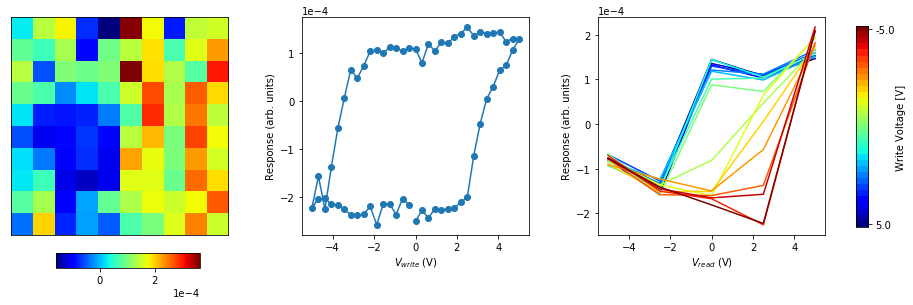

In [7]:
# Specify 'coordinates'
x = 2
y = 2
read_ = 3
write_ = 15
# do plotting
make_simple_fig(R_true, bias_vec_r, bias_vec_w, x, y, write_, read_, sci_scale=True)

### Prepare data

Normalize data for GP analysis and get grid indices:

In [8]:
e1, e2, e3, e4 = R_true.shape # will need them later
R_true = (R_true - np.amin(R_true)) / np.ptp(R_true)
X_true = gprutils.get_grid_indices(R_true)
print(X_true.shape, R_true.shape)

(4, 10, 10, 64, 5) (10, 10, 64, 5)


### Train model and make a prediction

Train a GP model:

In [9]:
reconstructor = skgpr.skreconstructor(
    X=X_true, y=R_true, Xtest=X_true,
    kernel='Matern52', iterations=50, 
    verbose=True, use_gpu=True,
)
reconstructor.train()

Model training...
iter: 0 ... loss: 0.8109 ... length: [0.7444 0.7444 0.7444 0.7444] ... noise: 0.6444967 ...
iter: 10 ... loss: 0.3719 ... length: [1.2475 1.2475 1.2475 1.2475] ... noise: 0.2853718 ...
average time per iteration: 3.598 s
iter: 20 ... loss: -0.0902 ... length: [1.938 1.938 1.938 1.938] ... noise: 0.1113238 ...
iter: 30 ... loss: -0.5683 ... length: [2.7794 2.7794 2.7794 2.7794] ... noise: 0.0405557 ...
iter: 40 ... loss: -1.0219 ... length: [3.4905 3.4905 3.4905 3.4905] ... noise: 0.0146289 ...
iter: 49 ... loss: -1.3825 ... length: [3.61 3.61 3.61 3.61] ... noise: 0.0060748 ...
training completed in 162.75 s
Final parameter values:
 lengthscale: [3.61 3.61 3.61 3.61], noise: 0.0060748


Apply the trained model to the original grid points:

In [10]:
# consider decreasing max_root if doesn't fit into memory
mean = reconstructor.predict(max_root=100)

Calculating predictive mean...
Batch 10/10
Done


Plot results:

Original data


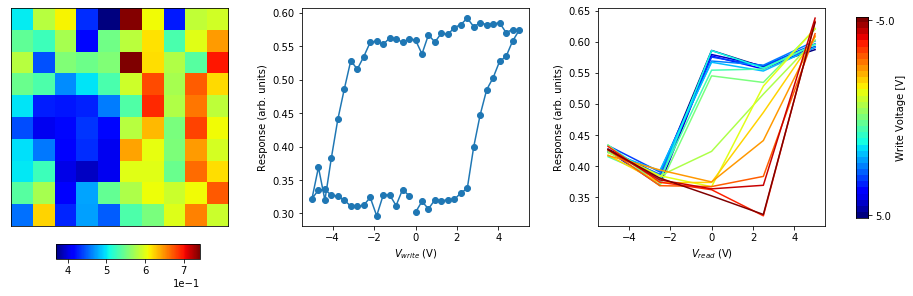

GP prediction


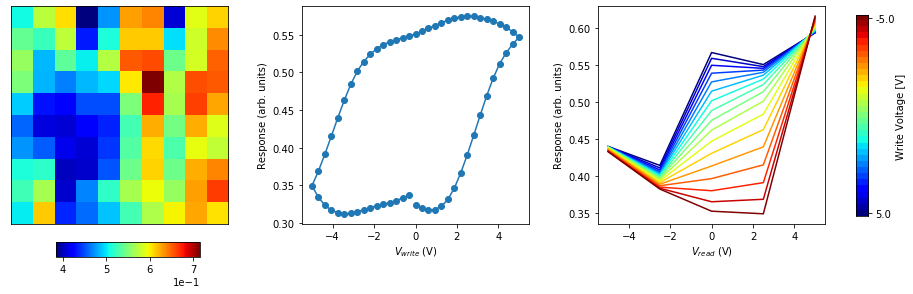

In [11]:
x = 2 # select x
y = 2 # select y
read_ = 3 # select V_read
write_ = 15 # select V_write

print('Original data')
make_simple_fig(R_true, bias_vec_r, bias_vec_w, x, y, write_, read_)
print('GP prediction')
make_simple_fig(mean.reshape(e1, e2, e3, e4), 
                bias_vec_r, bias_vec_w, x, y, write_, read_)

Now we will apply the same trained model to a twice denser (in all 4 dimensions) grid. First get the new grid indices:

In [0]:
grx = 2 # increase resolution
bias_vec_r_2x = dense2x_r(bias_vec_r, grx)
bias_vec_w_2x = dense2x_w(bias_vec_w, grx)
ngr = 1/grx
Xtest_x = gprutils.get_grid_indices(R_true, dense_x=ngr)

Make a prediction for the new grid:

In [15]:
mean_2x = reconstructor.predict(Xtest=Xtest_x, max_root=100, num_batches=100)

Calculating predictive mean...
Batch 100/100
Done


Plot results:

GP prediction


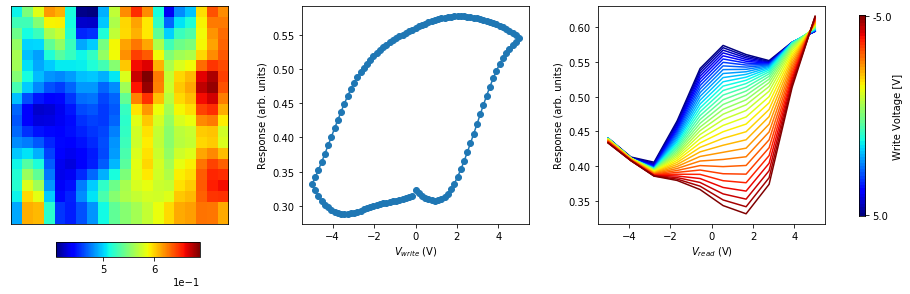

In [16]:
x = 4
y = 4
read_ = 6
write_ = 30
print('GP prediction')
e1t, e2t, e3t, e4t = Xtest_x.shape[1:]
mean_2x = mean_2x.reshape(e1t, e2t, e3t, e4t)
make_simple_fig(mean_2x, 
                bias_vec_r_2x, bias_vec_w_2x, x, y, write_, read_, 
                sci_scale=False)

### Multivariate analysis

We will now do tensor decompositions using a higher resolution data produced by GP. First, prepare the data:

In [0]:
resp_mat = mean_2x.copy()
bias_vec_w_for_plot = bias_vec_w_2x
bias_vec_r_for_plot = bias_vec_r_2x
dim0, dim1, dim2, dim3 = resp_mat.shape
ckpfm_data = tensorly.tensor(
    resp_mat.reshape(dim0*dim1, dim2, dim3))

Choose the rank of the decomposition and run the tensor decomposition. Note here we are doing a parafac decomposition, which does not require non-negativity. You can do NTF if you want by changing the parafac below to `non_negative_parafac`.

In [0]:
cp_rank = 2 #rank of decomposition
_, factors = parafac(ckpfm_data, rank=cp_rank, init='random', tol=1E-8, random_state=1000)

Plot results:

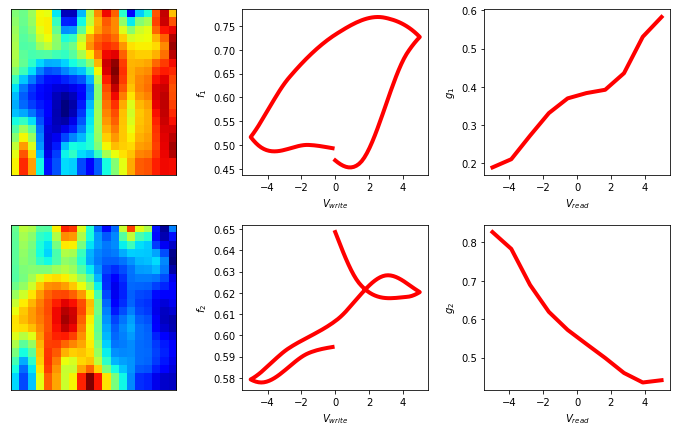

In [19]:
fig, axes = plt.subplots(nrows=cp_rank, ncols=3, figsize=(12,7))
for ind in range(cp_rank):
    axes[ind,0].imshow(factors[0][:,ind].reshape(dim0, dim1), cmap='jet')
    axes[ind, 0].set_xticks([])
    axes[ind, 0].set_yticks([])
    axes[ind,1].plot(bias_vec_w_for_plot, factors[1][:,ind], c='red', linewidth=4)
    axes[ind,1].set_xlabel('$V_{write}$')
    axes[ind,1].set_ylabel('$f_{}$'.format(ind+1))
    axes[ind,2].plot(bias_vec_r_for_plot[0,:], factors[2][:,ind], c='red', linewidth=4)
    axes[ind,2].set_xlabel('$V_{read}$')
    axes[ind,2].set_ylabel('$g_{}$'.format(ind+1))                     
plt.subplots_adjust(wspace=0.3, hspace=0.3)